In [57]:
import numpy as np
import lammps
from lammps import LMP_STYLE_ATOM, LMP_TYPE_ARRAY

# This a wrapper function and should be used with caution:
# Periodic datasets with  lammps-format style atomic is currently supported
# Wishlist:- a fitSNAP and LAMMPS-provided descriptor extraction function 

def SNAP(lmp_struc, cutfac, rfrac0, twojmax, R, w):
    '''
    Hyper-parmaters:

    cutfac = scale factor applied to all cutoff radii (positive real) : float

    rfac0 = parameter in distance to angle conversion (0 < rcutfac < 1) : float

    twojmax = band limit for bispectrum components (non-negative integer) : int

    R_1, R_2,… = list of cutoff radii, one for each type (distance units) : list

    w_1, w_2,… = list of neighbor weights, one for each type : list
    
    Returns
    --------
    BiSpec: Bispectrum components for each atoms
    '''

    lmp = lammps.lammps(cmdargs=['-sc','.lammps_output.txt', '-l', 'None'])
    
    R_max = max(R)
    R = ' '.join(map(str, R))
    w = ' '.join(map(str, w))
    
    
    doctring = f"""
    #LAMMPS input file
    # ------------------------ INITIALIZATION ----------------------------
    processors    * * *
    units         metal
    dimension    3
    boundary    p    p    p
    atom_style   atomic
    box tilt large
    #--------------------------- LAMMPS Data File -------------------------
    read_data     {lmp_struc}
    mass * 1.0
    #--------------------------- DUMMY FORCE_FIELD -------------------------
    pair_style      zero {cutfac*R_max*2}
    pair_coeff      * *  
    
    """
    try:
        lmp.commands_string(doctring)
    except Exception as e:
        raise RuntimeError(f'LAMMPS: {e}\n')

    #-------- Compute SNAP descriptors ---------------------        
    lmp.command(f'compute BiSpec all sna/atom {cutfac} {rfrac0} {twojmax} {R} {w}')
    
    try:
        lmp.command('run 0')
    except Exception as e:
        raise RuntimeError(f'LAMMPS: {e}\n')

    BiSpec = lmp.numpy.extract_compute('BiSpec', LMP_STYLE_ATOM, LMP_TYPE_ARRAY)
    t = lmp.gather_atoms('type',0,1)
    types = np.ctypeslib.as_array(t)
    
    lmp.close()
    
    return BiSpec, types



def lammps_minimizer(lmp_struc):

        lmp = lammps.lammps(cmdargs=['-sc','.lammps_output.txt'])
        
        doctring = f"""
        #LAMMPS input file
        # ------------------------ INITIALIZATION ----------------------------
        processors    * * *
        units         real
        dimension    3
        boundary    p    p    p
        atom_style   charge
        box tilt large
        #--------------------------- LAMMPS Data File -------------------------
        read_data     {lmp_struc}
        mass * 1.0
        #--------------------------- Reax FORCE_FIELD -------------------------
        pair_style reax/c NULL safezone 16.0 mincap 2400
        pair_coeff * * ffield_start Mo S
        fix 1 all qeq/reax 1 0.0 10.0 1.0e-6 reax/c
        """
        try:
                lmp.commands_string(doctring)
        except Exception as e:
                raise RuntimeError(f'LAMMPS: {e}\n')

        lmp.command('minimize 1e-5 1e-4 10000 10000')
        lmp.command(f'write_data min_{lmp_struc}')
        pe = lmp.get_thermo("pe")
        lmp.close()

        return pe

In [9]:
from qcad.StructureGenerators.initialize_database import pull_structures_from_MP
from pymatgen.io.lammps.data import LammpsData
from qcad.StructureGenerators.defect_generator import generate_vacancy_set

In [10]:
MATERIALS_PROJECT_API_KEY ='6oxeUB1cmDEftKuWhzHM3LnmeukTcBzA'

In [11]:
Bi_Se_set = pull_structures_from_MP(chemsys='Bi-Se', MATERIALS_PROJECT_API_KEY=MATERIALS_PROJECT_API_KEY, only_convex_hull=False)

Retrieving SummaryDoc documents:   0%|          | 0/19 [00:00<?, ?it/s]

In [12]:
Mo_Se_set = pull_structures_from_MP(chemsys='Mo-Se', MATERIALS_PROJECT_API_KEY=MATERIALS_PROJECT_API_KEY, only_convex_hull=False)
W_Se_set = pull_structures_from_MP(chemsys='W-Se', MATERIALS_PROJECT_API_KEY=MATERIALS_PROJECT_API_KEY, only_convex_hull=False)

Retrieving SummaryDoc documents:   0%|          | 0/16 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

In [58]:
ic = 2
lmp_struc = LammpsData.from_structure(Bi_Se_set['structures'][ic], atom_style='atomic')
fname = f'{'_'.join((Bi_Se_set['structures'][ic].formula.split()))}_{Bi_Se_set['material_id'][ic]}.lmp'
lmp_struc.write_file(fname)
bispec_descr, types = SNAP(lmp_struc=fname, cutfac=1, rfrac0=0.5, twojmax=8, R=[5,5], w=[1,1])

In [59]:
np.ctypeslib.as_array(types)

array([1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2], dtype=int32)

In [16]:
bispec_descr_list_1 = []
for ic in range(len(Bi_Se_set['structures'])):
        lmp_struc = LammpsData.from_structure(Bi_Se_set['structures'][ic], atom_style='atomic')
        fname = f'{'_'.join((Bi_Se_set['structures'][ic].formula.split()))}_{Bi_Se_set['material_id'][ic]}.lmp'
        lmp_struc.write_file(fname)
        bispec_descr = SNAP(lmp_struc=fname, cutfac=1, rfrac0=0.5, twojmax=8, R=[5,5], w=[1,1])
        # bispec_descr_list_1.append(np.linalg.norm(bispec_descr))
        d_sum = bispec_descr.sum(axis=0)
        bispec_descr_list_1.append(np.linalg.norm(d_sum))


In [17]:
bispec_descr_list_2 = []
for ic in range(len(Mo_Se_set['structures'])):
        lmp_struc = LammpsData.from_structure(Mo_Se_set['structures'][ic], atom_style='atomic')
        fname = f'{'_'.join((Mo_Se_set['structures'][ic].formula.split()))}_{Mo_Se_set['material_id'][ic]}.lmp'
        lmp_struc.write_file(fname)
        bispec_descr = SNAP(lmp_struc=fname, cutfac=1, rfrac0=0.5, twojmax=8, R=[5,5], w=[1,1])
        d_sum = bispec_descr.sum(axis=0)
        bispec_descr_list_2.append(np.linalg.norm(d_sum))

In [18]:
bispec_descr_list_3 = []
for ic in range(len(W_Se_set['structures'])):
        lmp_struc = LammpsData.from_structure(W_Se_set['structures'][ic], atom_style='atomic')
        fname = f'{'_'.join((W_Se_set['structures'][ic].formula.split()))}_{W_Se_set['material_id'][ic]}.lmp'
        lmp_struc.write_file(fname)
        bispec_descr = SNAP(lmp_struc=fname, cutfac=1, rfrac0=0.5, twojmax=8, R=[5,5], w=[1,1])
        d_sum = bispec_descr.sum(axis=0)
        bispec_descr_list_3.append(np.linalg.norm(d_sum))

In [7]:
import matplotlib.pyplot as plt
import numpy as np

Text(0, 0.5, 'norm. Energy')

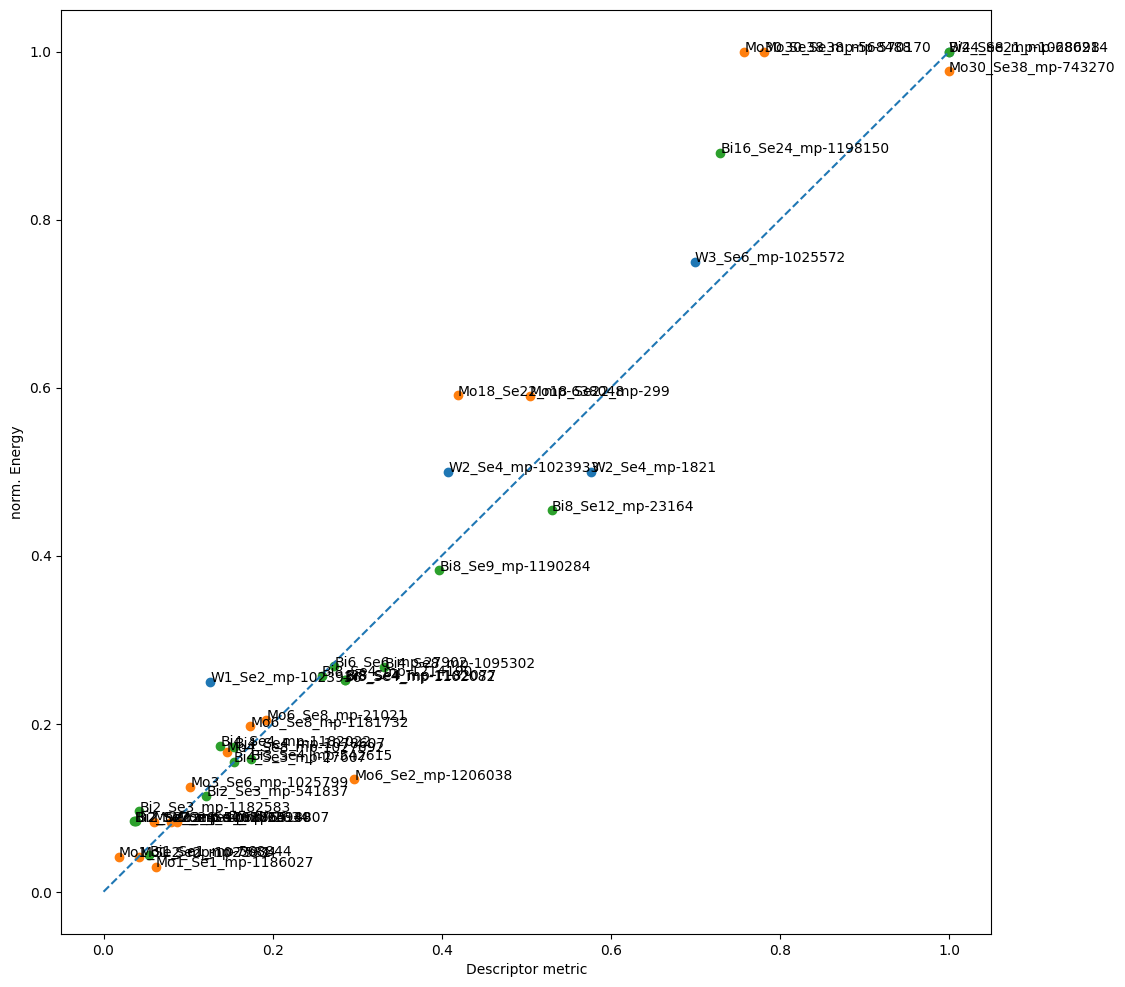

In [38]:
fig, ax = plt.subplots()

ax.scatter(np.array(bispec_descr_list_3)/max(bispec_descr_list_3), np.array(np.abs(W_Se_set['energy']))/max(np.abs(W_Se_set['energy'])), label='W_Se')
struc = W_Se_set
for ic in range(len(struc['structures'])):
        label= f'{'_'.join((struc['structures'][ic].formula.split()))}_{struc['material_id'][ic]}'
        ax.annotate(label, (np.array(bispec_descr_list_3)[ic]/max(bispec_descr_list_3), np.array(np.abs(struc['energy']))[ic]/max(np.abs(struc['energy']))))

struc = Mo_Se_set
ax.scatter(np.array(bispec_descr_list_2)/max(bispec_descr_list_2), np.array(np.abs(Mo_Se_set['energy']))/max(np.abs(Mo_Se_set['energy'])), label='Mo_Se')
for ic in range(len(struc['structures'])):
        label= f'{'_'.join((struc['structures'][ic].formula.split()))}_{struc['material_id'][ic]}'
        ax.annotate(label, (np.array(bispec_descr_list_2)[ic]/max(bispec_descr_list_2), np.array(np.abs(struc['energy']))[ic]/max(np.abs(struc['energy']))))

struc = Bi_Se_set
ax.scatter(np.array(bispec_descr_list_1)/max(bispec_descr_list_1), np.array(np.abs(Bi_Se_set['energy']))/max(np.abs(Bi_Se_set['energy'])), label='Bi_Se')
for ic in range(len(struc['structures'])):
        label= f'{'_'.join((struc['structures'][ic].formula.split()))}_{struc['material_id'][ic]}'
        ax.annotate(label, (np.array(bispec_descr_list_1)[ic]/max(bispec_descr_list_1), np.array(np.abs(struc['energy']))[ic]/max(np.abs(struc['energy']))))

plt.plot(np.arange(11)/10, np.arange(11)/10, '--')

plt.rcParams['figure.figsize'] = [12,12]
plt.legend
plt.xlabel('Descriptor metric')
plt.ylabel('norm. Energy')

Retrieving SummaryDoc documents:   0%|          | 0/23 [00:00<?, ?it/s]

Text(0, 0.5, 'norm. Energy')

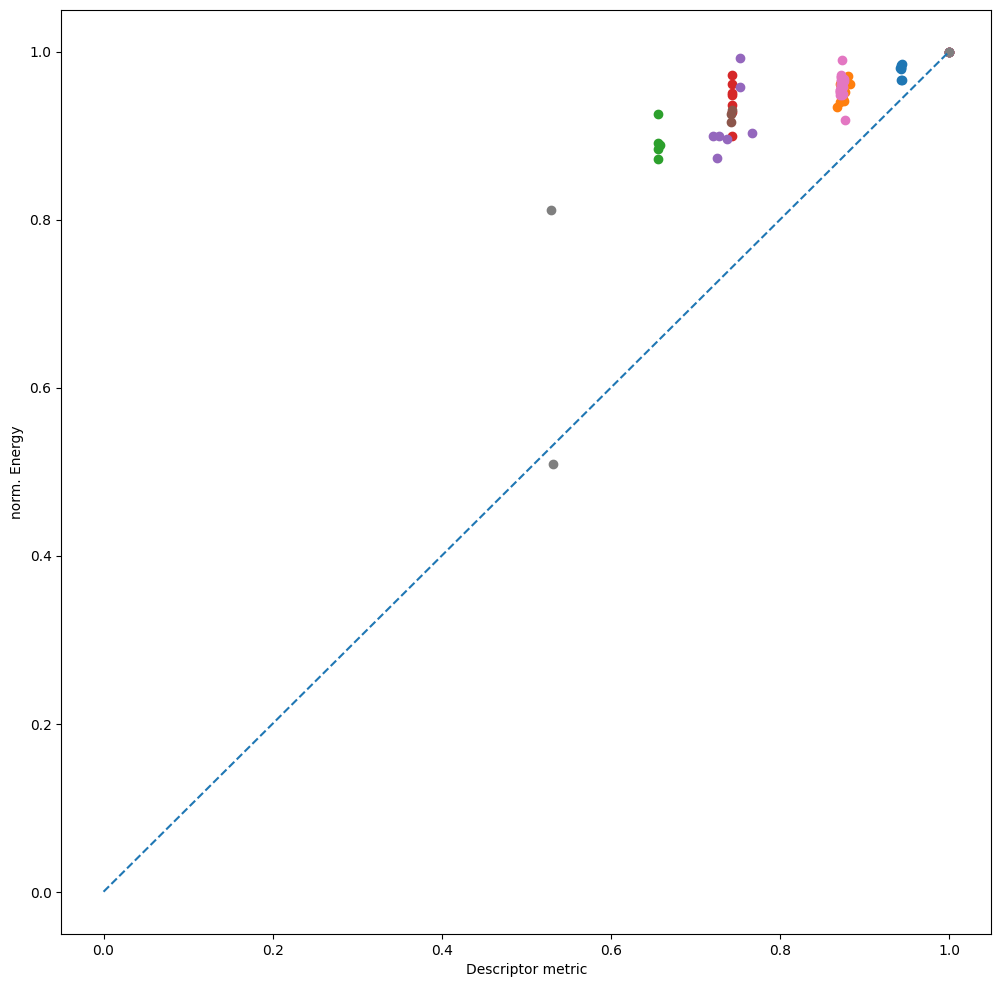

In [27]:
import matplotlib.pyplot as plt

Mo_S_set = pull_structures_from_MP(chemsys='Mo-S', MATERIALS_PROJECT_API_KEY=MATERIALS_PROJECT_API_KEY, only_convex_hull=True)
fig, ax = plt.subplots()

for ic in range(8):
        energy = []
        bispec = []
        labels = []
        lmp_struc = LammpsData.from_structure(Mo_S_set['structures'][ic], atom_style='charge')
        fname = f'{'_'.join((Mo_S_set['structures'][ic].formula.split()))}_{Mo_S_set['material_id'][ic]}.lmp'
        lmp_struc.write_file(fname)
        energy.append(lammps_minimizer(fname))
        bispec_descr = SNAP(lmp_struc='min_'+fname, cutfac=1, rfrac0=0.5, twojmax=8, R=[5,5], w=[1,1])
        # bispec_descr_pca, _ = compute_decriptor_PCA(bispec_descr.T, num_PC=50)
        d_sum = bispec_descr.sum(axis=0)
        bispec.append(np.linalg.norm(d_sum))
        vac_def = generate_vacancy_set(Mo_S_set['structures'][ic])
        labels.append( f'{'_'.join((Mo_S_set['structures'][ic].formula.split()))}_{Mo_S_set['material_id'][ic]}')


        for jc in range(len(vac_def['structures'])):
                lmp_struc = LammpsData.from_structure(vac_def['structures'][jc], atom_style='charge')
                fname = f'vac_{'_'.join((vac_def['structures'][jc].formula.split()))}_{Mo_S_set['material_id'][ic]}.lmp'
                lmp_struc.write_file(fname)
                energy.append(lammps_minimizer(fname))
                bispec_descr = SNAP(lmp_struc='min_'+fname, cutfac=1, rfrac0=0.5, twojmax=8, R=[5,5], w=[1,1])
                # bispec_descr_pca, _ = compute_decriptor_PCA(bispec_descr.T, num_PC=50)
                d_sum = bispec_descr.sum(axis=0)
                bispec.append(np.linalg.norm(d_sum))
                labels.append(f'vac_{'_'.join((vac_def['structures'][jc].formula.split()))}_{Mo_S_set['material_id'][ic]}')

                
                
        ax.scatter(np.array(bispec)/max(np.array(bispec)), np.array(np.abs(energy))/max(np.abs(np.array(energy))))
        # for ip in range(len(bispec)):
        #         ax.annotate(labels[ip], (np.array(bispec[ip])/max(np.array(bispec)), np.array(np.abs(energy[ip]))/max(np.abs(np.array(energy)))))
                


plt.plot(np.arange(11)/10, np.arange(11)/10, '--')
plt.rcParams['figure.figsize'] = [12,12]
plt.legend
plt.xlabel('Descriptor metric')
plt.ylabel('norm. Energy')






In [1]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def compute_decriptor_PCA(data, num_PC=3):
    """
    For reducing descriptor dimensions---> first standardize data and then apply PCA 
    
    Returns
    -------
    x: Principal components
    variances: Variance (eigenvalues of Cov matrix) ratio
    
    """
    scaling=StandardScaler()
    scaling.fit(data)
    Scaled_data=scaling.transform(data)
    # Set the n_components=3
    principal=PCA(n_components=num_PC)
    principal.fit(Scaled_data)
    x=principal.transform(Scaled_data)
    variances = principal.explained_variance_ratio_
    return x, variances

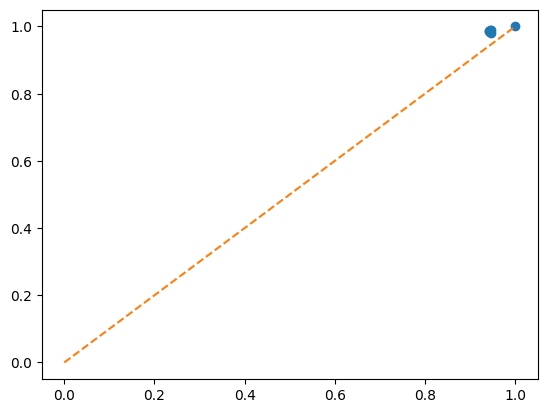

In [24]:
from qcad.StructureGenerators.initialize_database import pull_structures_from_MP
from qcad.StructureGenerators.defect_generator import generate_vacancy_set, generate_antisite_set, generate_substituion_set, generate_voronoi_set
from qcad.StructureGenerators.apply_deformation import apply_deformation_set


MATERIALS_PROJECT_API_KEY ='6oxeUB1cmDEftKuWhzHM3LnmeukTcBzA'
Bi_Se_set = pull_structures_from_MP(chemsys='Bi-Se', MATERIALS_PROJECT_API_KEY=MATERIALS_PROJECT_API_KEY, only_convex_hull=False)

def bootstrap_defect_structures(struc, mat_id, defect_type, energy_minimize=False):

        for jc in range(len(struc['structures'])):
                lmp_struc = LammpsData.from_structure(struc['structures'][jc], atom_style='charge')
                fname = f'{defect_type}_{'_'.join((struc['structures'][jc].formula.split()))}_{mat_id}.lmp'
                lmp_struc.write_file(fname)

                """
                if energy_minimize:
                        energy =  lammps_minimizer(fname)

                bispec_descr = SNAP(lmp_struc='min_'+fname, cutfac=1, rfrac0=0.5, twojmax=8, R=[5,5], w=[1,1])
                
                """
                if defect_type=='int' or defect_type=='sub':
                        try:
                                bispec_descr = SNAP(lmp_struc=fname, cutfac=1, rfrac0=0.5, twojmax=8, R=[5,5,5], w=[1,1,1])
                        except:
                                pass
                else:
                        try:
                                bispec_descr = SNAP(lmp_struc=fname, cutfac=1, rfrac0=0.5, twojmax=8, R=[5,5], w=[1,1])
                        except:
                                pass
                # bispec_descr_pca, _ = compute_decriptor_PCA(bispec_descr.T, num_PC=50)
                # d_sum = bispec_descr.sum(axis=0)
                try:        
                        bispec_descr_norm = np.linalg.norm(bispec_descr, axis=1)
                        
                except:
                        bispec_descr_norm = []
                # labels.append(f'{defect_type}_{'_'.join((struc['structures'][jc].formula.split()))}_{struc['material_id']}')

                return bispec_descr_norm




Retrieving SummaryDoc documents:   0%|          | 0/19 [00:00<?, ?it/s]

In [25]:
descr_list = []

for ic in range(len(Bi_Se_set['structures'])):
        lmp_struc = LammpsData.from_structure(Bi_Se_set['structures'][ic], atom_style='charge')
        fname = f'{'_'.join((Bi_Se_set['structures'][ic].formula.split()))}_{Bi_Se_set['material_id'][ic]}.lmp'
        lmp_struc.write_file(fname)
        bispec_descr = SNAP(lmp_struc=fname, cutfac=1, rfrac0=0.5, twojmax=8, R=[5,5], w=[1,1])
        # bispec_descr_list_1.append(np.linalg.norm(bispec_descr))
        d_sum = bispec_descr.sum(axis=0)
        descr_list.append(np.linalg.norm(bispec_descr,axis=1))

        #generate vacancies
        vac_def = generate_vacancy_set(Bi_Se_set['structures'][ic])
        descr_list.append(bootstrap_defect_structures(vac_def,Bi_Se_set['material_id'][ic], defect_type='vac'))

        #generate antisites
        anti_def = generate_antisite_set(Bi_Se_set['structures'][ic])
        descr_list.append(bootstrap_defect_structures(anti_def,Bi_Se_set['material_id'][ic], defect_type='anti'))

        #generate interstials 
        int_def = generate_voronoi_set(Bi_Se_set['structures'][ic],insert_species=['Nb'])
        descr_list.append(bootstrap_defect_structures(int_def, Bi_Se_set['material_id'][ic], defect_type='int'))

        #generate substituions
        sub_def = generate_substituion_set(Bi_Se_set['structures'][ic], substitution={'Bi': 'Nb'})
        descr_list.append(bootstrap_defect_structures(sub_def, Bi_Se_set['material_id'][ic], defect_type='sub'))

        #apply deformation
        deform_set = apply_deformation_set(Bi_Se_set['structures'][ic])
        descr_list.append(bootstrap_defect_structures(deform_set, Bi_Se_set['material_id'][ic], defect_type='deform'))
        

        



In [30]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler

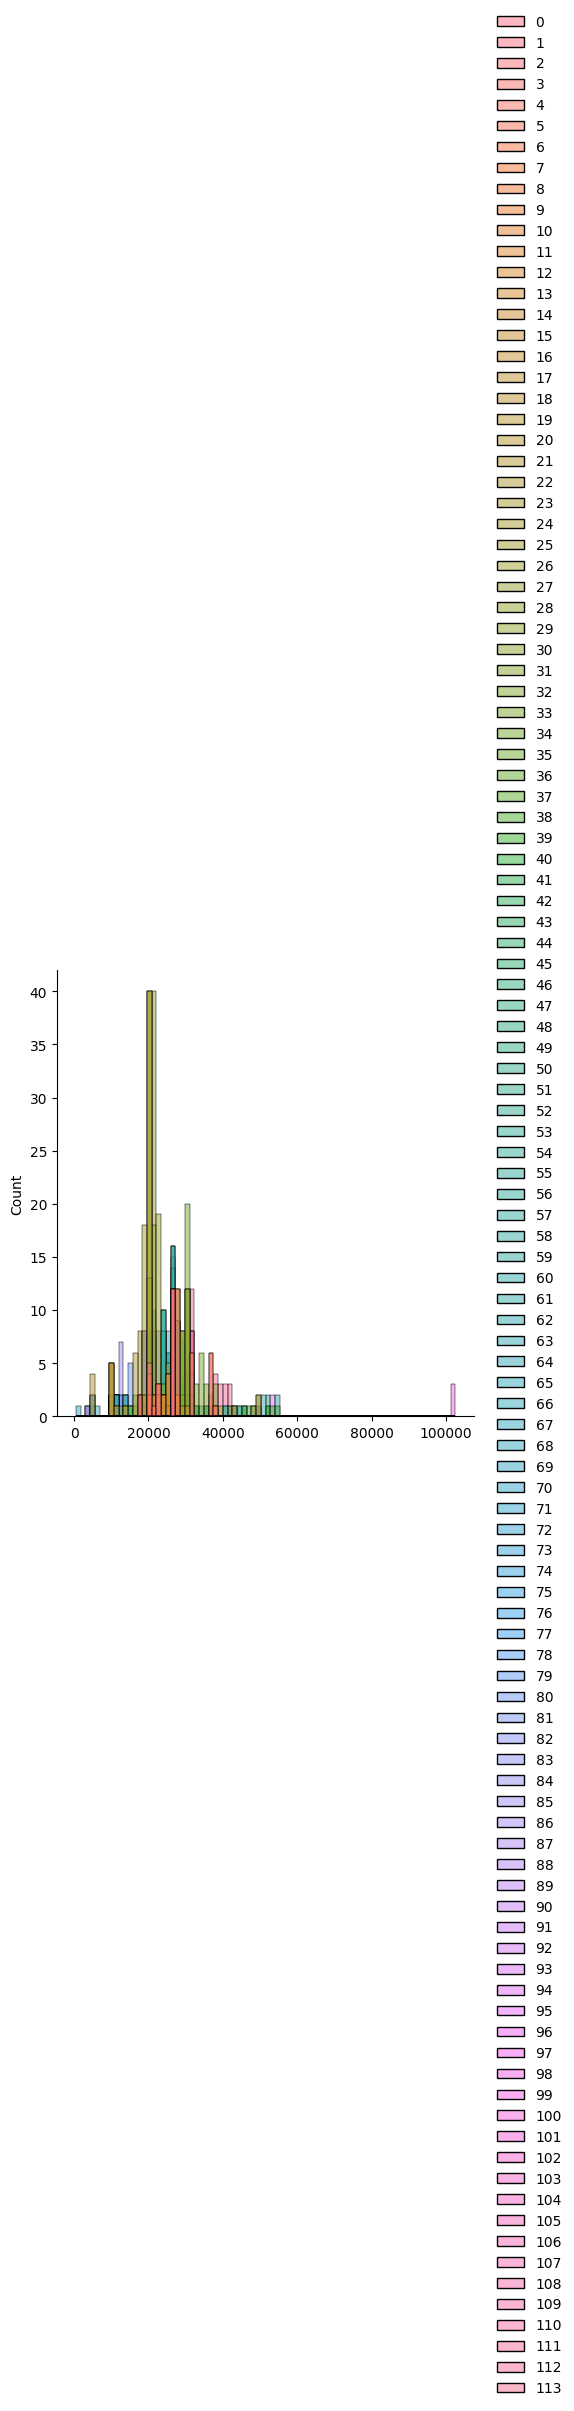

In [32]:
# scaling=StandardScaler()
# scaling.fit(descr_list)
# Scaled_data=scaling.transform(descr_list)
ax = sns.displot(descr_list)

In [28]:
np.array(descr_list,

[array([26817.24599455, 26817.24600246, 26817.24599455, 26817.24600246,
        26809.30273757, 26809.30270554, 26809.30273757, 26809.30270554,
        26760.17366511, 26760.17368335, 26760.17366511, 26760.17368335]),
 array([23278.36343994, 21173.77100211, 20357.05375575, 18238.51062838,
        23281.37152423, 20831.96166495, 20474.27543205, 23250.79040884,
        18244.96910062, 20656.6862621 , 20577.81767817]),
 array([26817.24599455, 26817.24600246, 26817.24599455, 26817.24600246,
        26809.30273757, 26809.30270554, 26809.30273757, 26809.30270554,
        26760.17366511, 26760.17368335, 26760.17366511, 26760.17368335]),
 array([37543.20817382, 31866.65877717, 36621.35256667, 32057.95714655,
        36368.83230539, 31609.5902977 , 36691.3596612 , 31807.6954099 ,
        36695.35475502, 36970.13229288, 31421.9475682 , 36653.58947872,
        31536.48343286]),
 array([26817.24599455, 26817.24600246, 26817.24599455, 26817.24600246,
        26809.30273757, 26809.30270554, 26809.30